In [3]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
import pyarrow as pa

print(f" [i] Start analyzing, total 8 steps...")
print(f" [i] Setting up...")

# 強制 Qt 在 Linux 環境下使用 X11
os.environ["QT_QPA_PLATFORM"] = "xcb"

# 防止 NumPy 佔用過多記憶體
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# 固定隨機種子確保可重現性
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

 [i] Start analyzing, total 8 steps...
 [i] Setting up...


In [4]:
def load_metadata_labels(metadata_path, df_index, target_tissues=None):
    print(f" [i] Reading tissue metadata...")
    metadata_df = pd.read_csv(metadata_path, sep="\t", low_memory=False, usecols=["SAMPID", "SMTSD"])
    metadata_df["GTEX_ID"] = metadata_df["SAMPID"].str.split("-").str[:2].str.join("-")
    gtex_tissue_dict = metadata_df.set_index("GTEX_ID")["SMTSD"].to_dict()

    sample_ids = df_index.str.split("-").str[:2].str.join("-")
    tissue_labels = sample_ids.map(gtex_tissue_dict).fillna("Unknown").tolist()

    if target_tissues is not None:
        tissue_labels = [label if label in target_tissues else "Other" for label in tissue_labels]

    return tissue_labels

In [5]:
def load_hgnc_protein_coding(filepath):
    df = pd.read_csv(filepath, sep="\t")
    df = df[df["Approved symbol"].str.startswith(("RPL", "RPS"), na = False)]
    df = df.dropna(subset=["Ensembl gene ID"]) # 確保 Ensembl gene ID 不是 NaN
    # print(df)
    return dict(zip(df["Ensembl gene ID"], df["Approved symbol"]))

# 設定本地 HGNC 資料檔案
print(f" [i] Reading HGNC protein coding gene...")
hgnc_file = r"~/gct_data/hgnc_protein_coding.tsv"
ensembl_to_symbol = load_hgnc_protein_coding(hgnc_file)
print(f" [i] Ribosomal Protein gene count: {len(ensembl_to_symbol)}")

def load_gct(filepath):
    """
    逐行解析 GCT 檔案，確保數據格式一致，避免記憶體使用過高。
    """
    print(" [1] Detecting column names...")
    with open(filepath, "r") as f:
        lines = f.readlines()
    header_line = lines[2]  # `.gct` 的標題通常在第 3 行（index 2）
    column_names = header_line.strip().split("\t")
    gene_id_column = column_names[0]
    print(f" [2] Detected Gene_ID column: {gene_id_column}")

    print(" [3] Streaming GCT data...", end = "\n")
    print(" [i] This may take a few minutes, please wait...", end = "\n")
    def process_chunk(chunk):
        chunk = chunk.rename(columns={gene_id_column: "Gene_ID"})
        chunk["Gene_ID"] = chunk["Gene_ID"].astype(str)
        chunk.set_index("Gene_ID", inplace=True)

        # 🔹 確保基因 ID 的格式與 ensembl_to_symbol 一致（去掉 .X 後綴）
        chunk.index = chunk.index.str.split('.').str[0]

        # 🔹 確保 index 不是 None
        if chunk.index is None or chunk.empty:
            return pd.DataFrame()

        return chunk[chunk.index.isin(ensembl_to_symbol)]

    chunk_size = 10000
    filtered_data = []

    with pd.read_csv(filepath, sep="\t", skiprows=2, chunksize=chunk_size) as reader:
        for chunk in reader:
            processed_chunk = process_chunk(chunk)
            filtered_data.append(pa.Table.from_pandas(processed_chunk))

    print(" [4] Merging processed data...")
    final_table = pa.concat_tables(filtered_data)
    df = final_table.to_pandas()
    if "Description" in df.columns:
        df.drop(columns=["Description"], inplace=True)
    df = df.T
    
    print(df.shape)
    
    return df

 [i] Reading HGNC protein coding gene...
 [i] Ribosomal Protein gene count: 1765


In [6]:
# 預處理數據
def preprocess_data(df):
    print(" [5] Pre-processing data...")
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df = df.select_dtypes(include=[np.number])  # 只保留數值欄位
    data_scaled = scaler.fit_transform(df)
    return data_scaled, data_scaled.shape

In [7]:
# PCA 降維
def perform_pca_np(data, n_components=50):
    print(" [6] Performing PCA_NP...")
    data = data.astype(np.float32)
    mean = np.mean(data, axis=0)
    data_centered = data - mean
    U, S, Vt = svds(data_centered, k=n_components)
    return np.dot(data_centered, Vt.T)

In [8]:
# t-SNE 降維
def perform_tsne_np(data, n_components=2, perplexity=30, learning_rate=500, max_iter=2000):
    print(" [7] Performing t-SNE_NP...")
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, max_iter=max_iter)
    return tsne.fit_transform(data)

In [9]:
# 繪製 t-SNE 圖形
def plot_tsne(tsne_results, tissue_labels, output_path):
    print(" [8] Drawing t-SNE plot...")
    plt.figure(figsize=(19.2, 10.8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=tissue_labels, palette='Set2', s=50, edgecolor="black", alpha=0.8)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.title("t-SNE visualization of GTEx Data")
    plt.legend(title="Tissues", bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()  # 確保圖例不會超出畫布
    plt.savefig(output_path, dpi=300)
    print(f" [i] t-SNE figure is saved as: {output_path}")

 [1] Detecting column names...
 [2] Detected Gene_ID column: Name
 [3] Streaming GCT data...
 [i] This may take a few minutes, please wait...
 [4] Merging processed data...
(19616, 1734)
 [i] Reading tissue metadata...
 [5] Pre-processing data...
 [6] Performing PCA_NP...
 [7] Performing t-SNE_NP...
 [8] Drawing t-SNE plot...
 [i] t-SNE figure is saved as: /home/terry_0714/tsne_plot/tsne_plot_new_6.png
 [i] t-SNE analysis is completed.
 [i] Time spent: 0 hours, 15 minutes and 17 seconds.


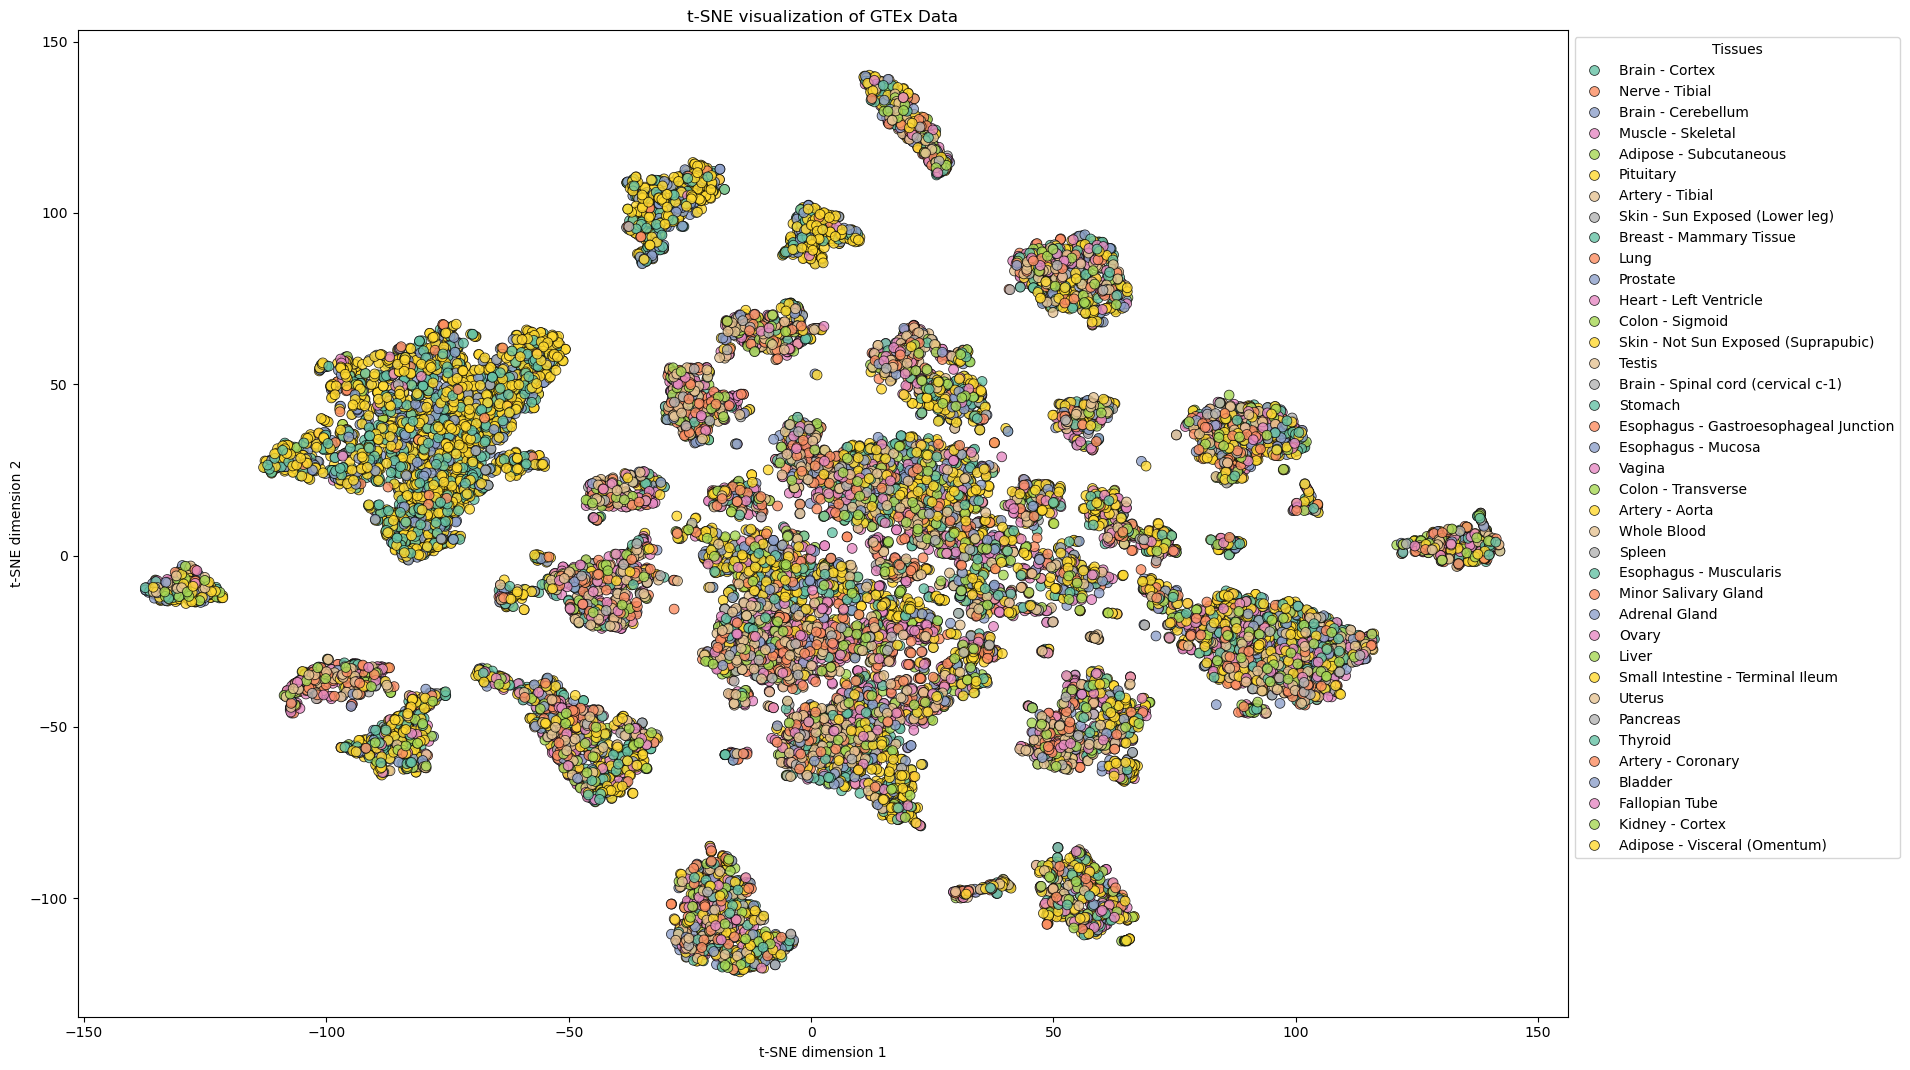

In [10]:
# 主執行流程
if __name__ == "__main__":
    start = time.time()
    gct_file = r"/home/terry_0714/gct_data/GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_tpm_non_lcm.gct"
    metadata_path = r"/home/terry_0714/gct_data/GTEx_Analysis_v10_Annotations_SampleAttributesDS.tsv"
    output_image = r"/home/terry_0714/tsne_plot/tsne_plot_new_6.png"
    # 讀取 GCT 檔案
    df = load_gct(gct_file)
    tissue_labels = load_metadata_labels(metadata_path, df.index)
    
    # 資料預處理
    processed_data, shape = preprocess_data(df)
    
    # 資料降維
    pca_data = perform_pca_np(processed_data)
    
    # t-SNE 降維
    tsne_results = perform_tsne_np(pca_data)
    
    # 作圖
    plot_tsne(tsne_results, tissue_labels, output_image)
    print(" [i] t-SNE analysis is completed.")

    end = time.time()
    elapsed_time = int(end - start)
    hours = elapsed_time // 3600
    minutes = elapsed_time % 3600 // 60
    seconds = elapsed_time % 60

    print(f" [i] Time spent: {hours} hours, {minutes} minutes and {seconds} seconds.")